In [1]:

!pip install xgboost optuna shap matplotlib seaborn scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from xgboost import XGBClassifier, plot_importance
import shap
import optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 14.9 MB/s eta 0:00:00


In [2]:
df = pd.read_csv("Dataset Datathon - Sheet1 (1).csv")  # ganti dengan path file kamu

print(df.head())
print(df.info())
print(df.describe())
print("Missing values per kolom:")
print(df.isna().sum())


  Kabupaten/Kota  Tahun  Luas Wilayah  Indeks Pembangunan Manusia (IPM)  \
0        Pacitan   2020       1389.92                             69.28   
1       Ponorogo   2020       1305.70                             71.57   
2     Trenggalek   2020       1147.22                             70.10   
3    Tulungagung   2020       1055.65                             73.15   
4         Blitar   2020       1336.48                             71.02   

   Harapan Lama Sekolah (Tahun)  Rata-rata Lama sekolah (Tahun)  \
0                         12.64                            7.60   
1                         13.73                            7.54   
2                         12.35                            7.55   
3                         13.31                            8.33   
4                         12.46                            7.39   

   Angka Partisipasi Sekolah (APS) Usia 7-12 (Persen)  \
0                                              99.82    
1                               

In [3]:
df.columns = df.columns.str.strip().str.replace("\n","").str.replace("\r","").str.replace("  "," ")

print(df.columns)

num_cols = df.drop(columns=["Kabupaten/Kota", "Tahun"], errors='ignore').select_dtypes(include='number').columns
df[num_cols] = df[num_cols].astype(float)
print(df.dtypes)


Index(['Kabupaten/Kota', 'Tahun', 'Luas Wilayah',
       'Indeks Pembangunan Manusia (IPM)', 'Harapan Lama Sekolah (Tahun)',
       'Rata-rata Lama sekolah (Tahun)',
       'Angka Partisipasi Sekolah (APS) Usia 7-12 (Persen)',
       'Angka Partisipasi Sekolah (APS) Usia 13-15 (Persen)',
       'Angka Partisipasi Sekolah (APS) Usia 16-18 (Persen)',
       'Angka Partisipasi Sekolah (APS) Usia 19-23 (Persen)',
       'Rasio Guru per Siswa', 'Persentase Penduduk (Persen)',
       'Persentase Penduduk Miskin (Persen)',
       'Tingkat Pengangguran Terbuka (TPT) - Agustus',
       'Tingkat Partisipasi Angkatan Kerja - Agustus',
       'Pengeluaran Per Kapita Riil Disesuaikan (Ribu Rupiah)',
       'Persentase Rumah Tangga dengan Akses Air Bersih',
       'Laju Pertumbuhan Penduduk per Tahun (persen)',
       'Kepadatan Penduduk per km persegi (km²)', 'Gini Ratio',
       'Jumlah masyarakat miskin dan tidak mampu yang dapatmengakses pelayanan kesehatan (orang)',
       'Jumlah Penerima Bans

label
Tidak Rentan    82
Rentan          72
Sedang          36
Name: count, dtype: int64


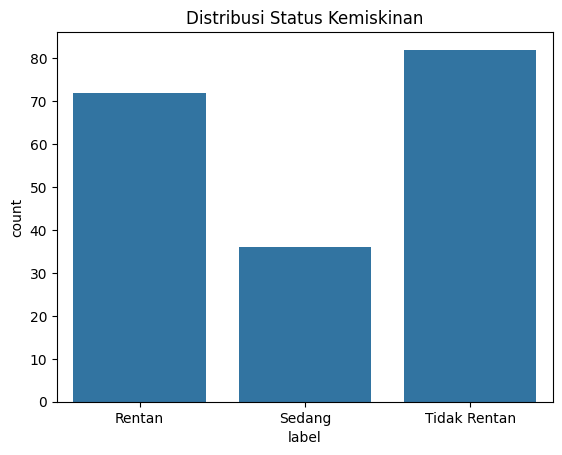

In [4]:
def categorize_poverty(rate):
    if rate >= 11:
        return "Rentan"
    elif rate >= 9.5:
        return "Sedang"
    else:
        return "Tidak Rentan"

df["label"] = df["Persentase Penduduk Miskin (Persen)"].apply(categorize_poverty)

label_map = {"Tidak Rentan":0, "Sedang":1, "Rentan":2}
df["label_num"] = df["label"].map(label_map)
print(df["label"].value_counts())
sns.countplot(x="label", data=df)
plt.title("Distribusi Status Kemiskinan")
plt.show()


In [5]:
missing = df.isna().sum()
print(missing[missing>0])

num_cols = df.select_dtypes(include=['float64','int64']).columns.drop(['label_num', 'Persentase Penduduk Miskin (Persen)'], errors='ignore')
for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)

cat_cols = df.select_dtypes(include=['object']).columns.drop('label', errors='ignore')
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

print(df.isna().sum().sum())


Series([], dtype: int64)
0


/tmp/ipython-input-1409216480.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipython-input-1409216480.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

/tmp/ipython-input-130491323.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=df, palette="Set2")


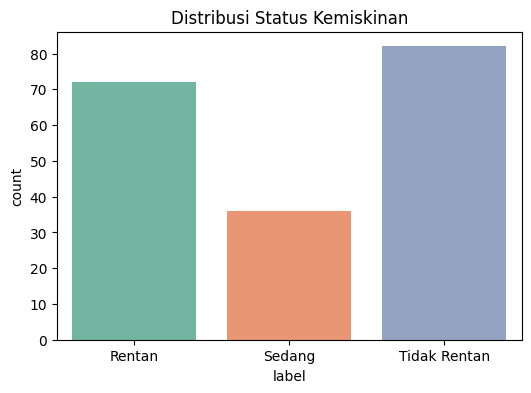

label
Tidak Rentan    43.157895
Rentan          37.894737
Sedang          18.947368
Name: proportion, dtype: float64


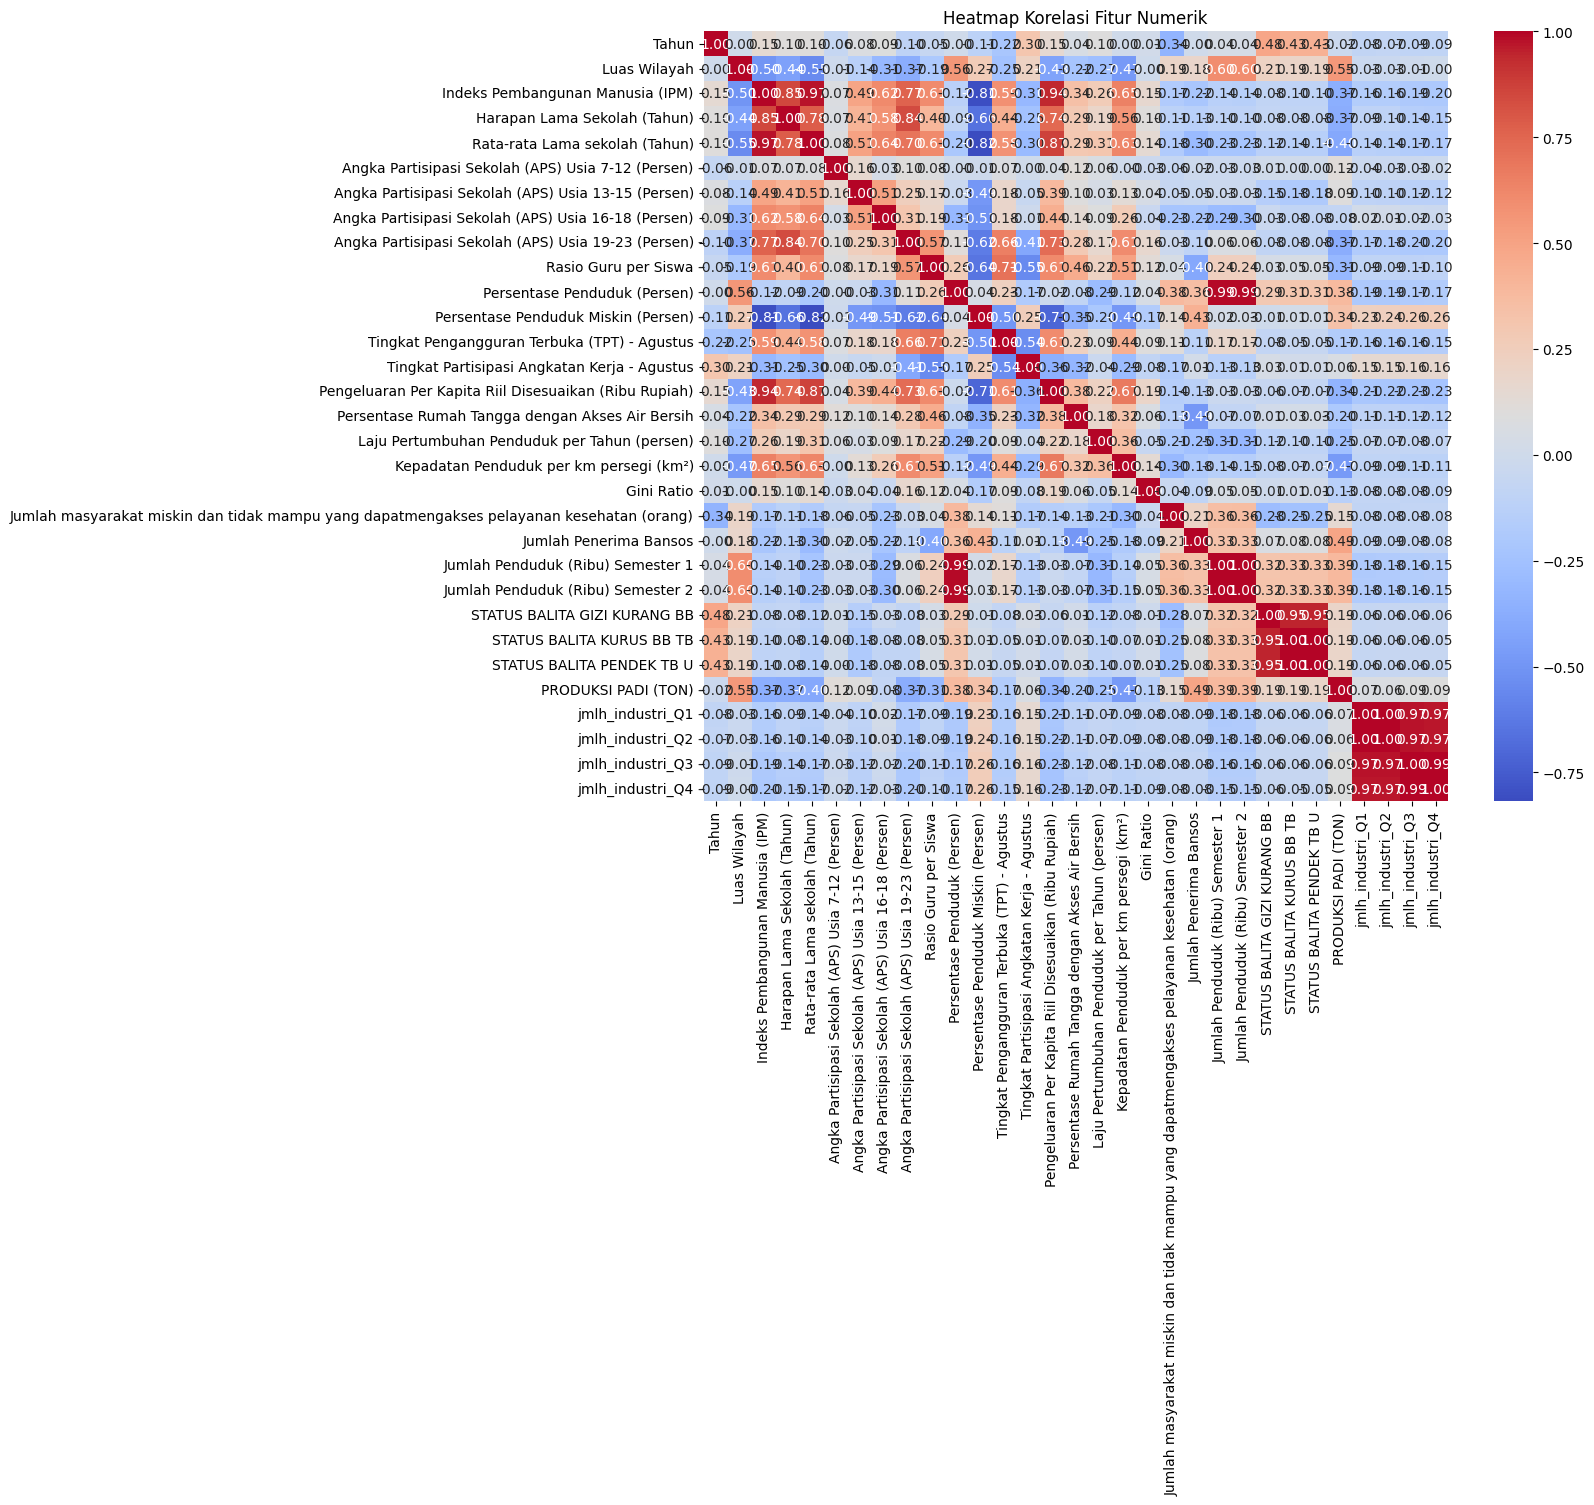

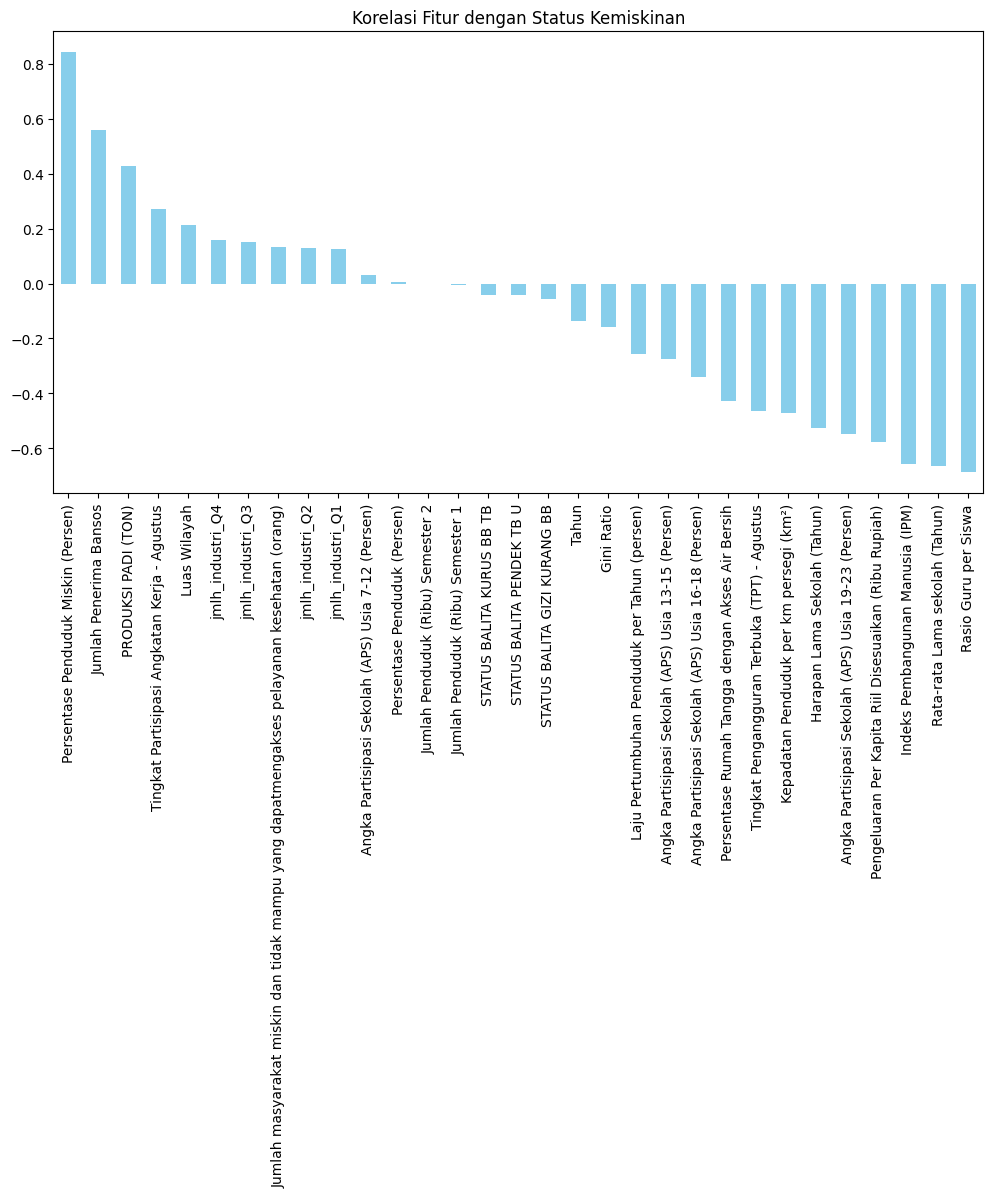

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(x="label", data=df, palette="Set2")
plt.title("Distribusi Status Kemiskinan")
plt.show()

print(df["label"].value_counts(normalize=True)*100)

plt.figure(figsize=(12,10))
num_df = df.select_dtypes(include=['float64','int64']).drop(columns=["label_num"], errors='ignore')
corr = num_df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Heatmap Korelasi Fitur Numerik")
plt.show()

plt.figure(figsize=(12,6))
corr_target = num_df.corrwith(df["label_num"]).sort_values(ascending=False)
corr_target.plot(kind="bar", color="skyblue")
plt.title("Korelasi Fitur dengan Status Kemiskinan")
plt.show()


In [7]:
from sklearn.model_selection import StratifiedKFold

X = df.drop(columns=["Persentase Penduduk Miskin (Persen)", "Kabupaten/Kota", "Tahun", "label", "label_num"])
y = df["label_num"]

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    y_train_fold = y.iloc[train_idx]
    print(f"Fold {fold}:")
    print(y_train_fold.value_counts(normalize=True)*100)


Fold 1:
label_num
0    43.421053
2    37.500000
1    19.078947
Name: proportion, dtype: float64
Fold 2:
label_num
0    43.421053
2    37.500000
1    19.078947
Name: proportion, dtype: float64
Fold 3:
label_num
0    43.421053
2    38.157895
1    18.421053
Name: proportion, dtype: float64
Fold 4:
label_num
0    42.763158
2    38.157895
1    19.078947
Name: proportion, dtype: float64
Fold 5:
label_num
0    42.763158
2    38.157895
1    19.078947
Name: proportion, dtype: float64


In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

acc_scores = []
f1_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    model = XGBClassifier(
        objective="multi:softprob",
        num_class=3,
        eval_metric="mlogloss",
        learning_rate=0.1,
        max_depth=6,
        n_estimators=300,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    model.fit(X_train_fold, y_train_fold)

    y_pred_fold = model.predict(X_val_fold)

    acc = accuracy_score(y_val_fold, y_pred_fold)
    f1 = f1_score(y_val_fold, y_pred_fold, average='weighted')

    acc_scores.append(acc)
    f1_scores.append(f1)

    print(f"Fold {fold}: Accuracy = {acc:.4f}, F1 = {f1:.4f}")

print(f"\nMean Accuracy (CV) = {np.mean(acc_scores):.4f}")
print(f"Mean Weighted F1 (CV) = {np.mean(f1_scores):.4f}")


Fold 1: Accuracy = 0.9211, F1 = 0.9224
Fold 2: Accuracy = 0.8158, F1 = 0.7911
Fold 3: Accuracy = 0.8421, F1 = 0.8391
Fold 4: Accuracy = 0.6842, F1 = 0.6842
Fold 5: Accuracy = 0.8684, F1 = 0.8639

Mean Accuracy (CV) = 0.8263
Mean Weighted F1 (CV) = 0.8201


In [9]:
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

def objective(trial):
    params = {
        'objective': 'multi:softprob',
        'num_class': 3,
        'eval_metric': 'mlogloss',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'random_state': 42
    }

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    f1_scores = []

    for train_idx, val_idx in skf.split(X, y):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

        model = XGBClassifier(**params)
        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_val_fold)
        f1_scores.append(f1_score(y_val_fold, y_pred, average='weighted'))

    return np.mean(f1_scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)

print("Best F1 (CV) :", study.best_value)
print("Best Params :", study.best_params)

[I 2025-09-09 15:39:54,767] A new study created in memory with name: no-name-9a494351-e3a3-4823-b80e-e570d2ef86be
[I 2025-09-09 15:39:58,544] Trial 0 finished with value: 0.7372552170749026 and parameters: {'learning_rate': 0.21209102741730532, 'max_depth': 3, 'n_estimators': 491, 'subsample': 0.6861131516657103, 'colsample_bytree': 0.980390687055377, 'gamma': 2.9531706755515974, 'min_child_weight': 10}. Best is trial 0 with value: 0.7372552170749026.
[I 2025-09-09 15:40:02,625] Trial 1 finished with value: 0.7590344660260439 and parameters: {'learning_rate': 0.2518016382280103, 'max_depth': 10, 'n_estimators': 338, 'subsample': 0.7952089791066932, 'colsample_bytree': 0.8988485114559834, 'gamma': 2.888492606308754, 'min_child_weight': 4}. Best is trial 1 with value: 0.7590344660260439.
[I 2025-09-09 15:40:05,856] Trial 2 finished with value: 0.7654141220528592 and parameters: {'learning_rate': 0.15946957847368562, 'max_depth': 8, 'n_estimators': 365, 'subsample': 0.6272759165379381, 'c

Best F1 (CV) : 0.7943232409432345
Best Params : {'learning_rate': 0.12109101004728981, 'max_depth': 9, 'n_estimators': 234, 'subsample': 0.6410873845353148, 'colsample_bytree': 0.8776387768012364, 'gamma': 0.7814959182380075, 'min_child_weight': 1}


Final Model Accuracy: 0.7894736842105263

Classification Report:
               precision    recall  f1-score   support

Tidak Rentan       0.87      0.76      0.81        17
      Sedang       0.45      0.71      0.56         7
      Rentan       1.00      0.86      0.92        14

    accuracy                           0.79        38
   macro avg       0.77      0.78      0.76        38
weighted avg       0.84      0.79      0.81        38



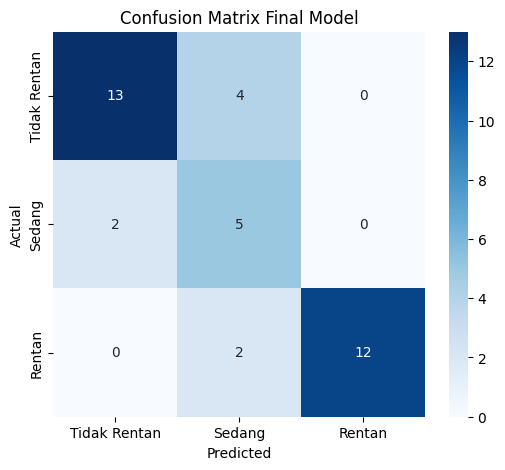

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, plot_importance

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

best_params = study.best_params
final_model = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    **best_params
)

final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)

print("Final Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["Tidak Rentan","Sedang","Rentan"]))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Tidak Rentan","Sedang","Rentan"], yticklabels=["Tidak Rentan","Sedang","Rentan"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Final Model")
plt.show()

X_test_copy = X_test.copy()
X_test_copy["Prediksi_Label_Num"] = y_pred
label_mapping = {0:"Tidak Rentan", 1:"Sedang", 2:"Rentan"}
X_test_copy["Prediksi_Label"] = X_test_copy["Prediksi_Label_Num"].map(label_mapping)
X_test_copy.to_csv("prediksi_kemiskinan_kesejahteraan_testset.csv", index=False)


In [11]:
X_test_copy.head()

,Luas Wilayah,Indeks Pembangunan Manusia (IPM),Harapan Lama Sekolah (Tahun),Rata-rata Lama sekolah (Tahun),Angka Partisipasi Sekolah (APS) Usia 7-12 (Persen),Angka Partisipasi Sekolah (APS) Usia 13-15 (Persen),Angka Partisipasi Sekolah (APS) Usia 16-18 (Persen),Angka Partisipasi Sekolah (APS) Usia 19-23 (Persen),Rasio Guru per Siswa,Persentase Penduduk (Persen),...,STATUS BALITA GIZI KURANG BB,STATUS BALITA KURUS BB TB,STATUS BALITA PENDEK TB U,PRODUKSI PADI (TON),jmlh_industri_Q1,jmlh_industri_Q2,jmlh_industri_Q3,jmlh_industri_Q4,Prediksi_Label_Num,Prediksi_Label
163,1669.87,70.65,13.20,6.90,99.28,98.93,69.59,11.28,10.63,1.68,...,18223.00,15497.0,15497.0,162236.8,1.329,1.334,1.362,1.377,2,Rentan
168,1115.09,75.16,13.61,8.77,99.74,98.37,84.42,21.30,14.30,3.26,...,50647.00,37842.0,37842.0,342291.3,2.958,3.030,3.091,3.194,1,Sedang
83,1790.90,68.48,12.02,6.87,99.95,97.33,53.00,15.25,13.86,2.76,...,7.15,6.2,6.2,300829.0,1.183,1.183,1.183,1.183,1,Sedang
115,1305.70,73.18,13.77,7.78,99.28,98.20,79.36,19.04,11.70,2.31,...,3446.00,2195.0,2195.0,392994.1,582.000,582.000,646.000,668.000,0,Tidak Rentan
0,1389.92,69.28,12.64,7.60,99.82,97.25,77.61,14.71,9.20,1.44,...,1576.00,827.0,827.0,83940.9,213.000,213.000,213.000,213.000,2,Rentan


Top 15 Factors Dominan Kesejahteraan:
                                              Feature      Gain
0                                        Luas Wilayah  5.301852
8                                Rasio Guru per Siswa  3.655785
18                             Jumlah Penerima Bansos  3.307181
23                                PRODUKSI PADI (TON)  2.196435
12  Pengeluaran Per Kapita Riil Disesuaikan (Ribu ...  2.158238
9                        Persentase Penduduk (Persen)  2.105931
3                      Rata-rata Lama sekolah (Tahun)  1.987749
2                        Harapan Lama Sekolah (Tahun)  1.926050
20                  Jumlah Penduduk (Ribu) Semester 2  1.914908
26                                   jmlh_industri_Q3  1.773456
11       Tingkat Partisipasi Angkatan Kerja - Agustus  1.639907
19                  Jumlah Penduduk (Ribu) Semester 1  1.618949
7   Angka Partisipasi Sekolah (APS) Usia 19-23 (Pe...  1.611940
1                    Indeks Pembangunan Manusia (IPM)  1.582476
17

<Figure size 1000x800 with 0 Axes>

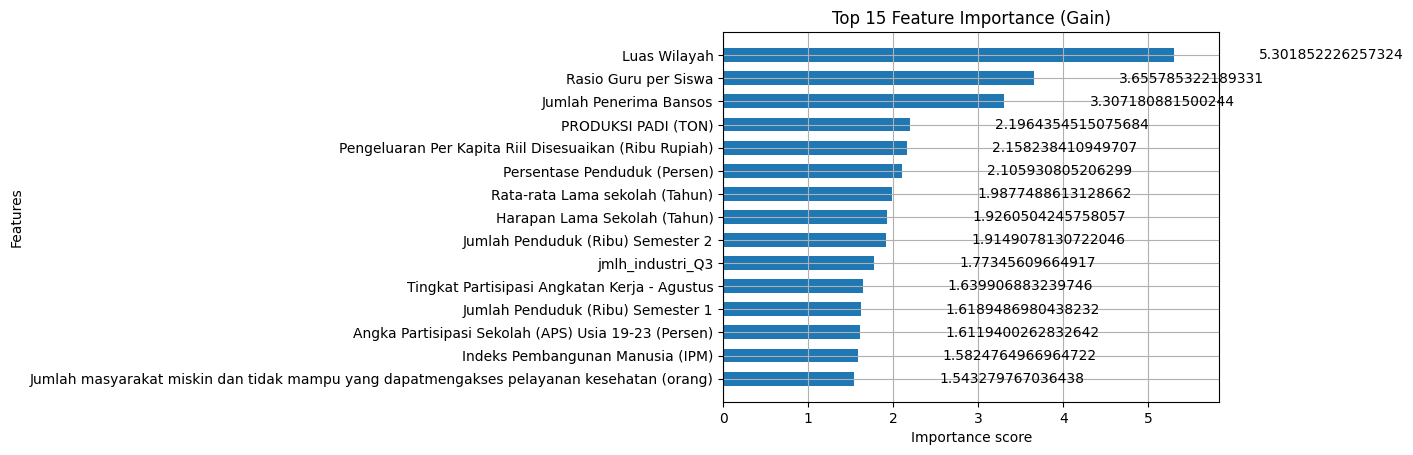

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Ambil importance dictionary
importance_dict = final_model.get_booster().get_score(importance_type='gain')

# Konversi ke DataFrame
importance_df = pd.DataFrame(
    list(importance_dict.items()),
    columns=['Feature', 'Gain']
).sort_values(by='Gain', ascending=False)

# Simpan top 15
top_factors = importance_df.head(15)
print("Top 15 Factors Dominan Kesejahteraan:")
print(top_factors)

# Export ke CSV
top_factors.to_csv("top_faktor_kesejahteraan.csv", index=False)

# Visualisasi
plt.figure(figsize=(10,8))
plot_importance(final_model, max_num_features=15, importance_type='gain', height=0.6)
plt.title("Top 15 Feature Importance (Gain)")
plt.show()


In [13]:
top_factors.head()

,Feature,Gain
0,Luas Wilayah,5.301852
8,Rasio Guru per Siswa,3.655785
18,Jumlah Penerima Bansos,3.307181
23,PRODUKSI PADI (TON),2.196435
12,Pengeluaran Per Kapita Riil Disesuaikan (Ribu ...,2.158238


/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


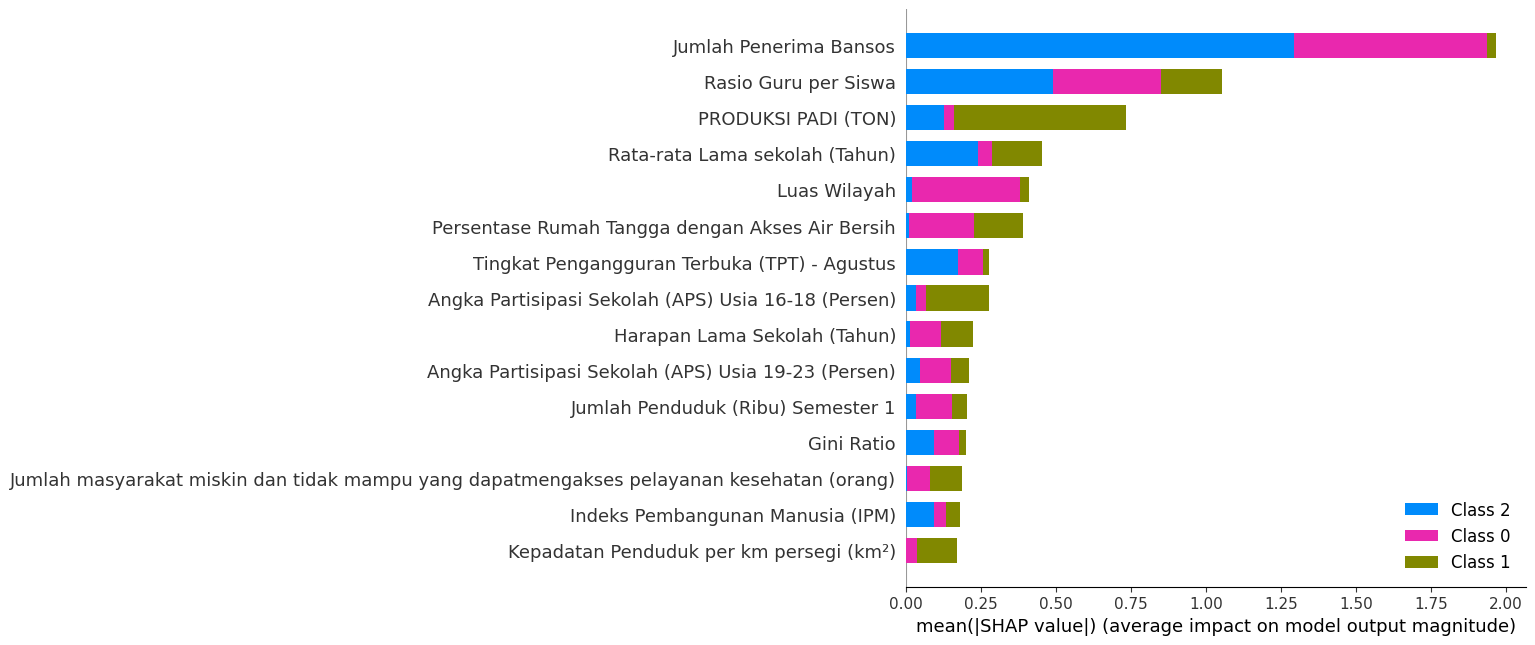

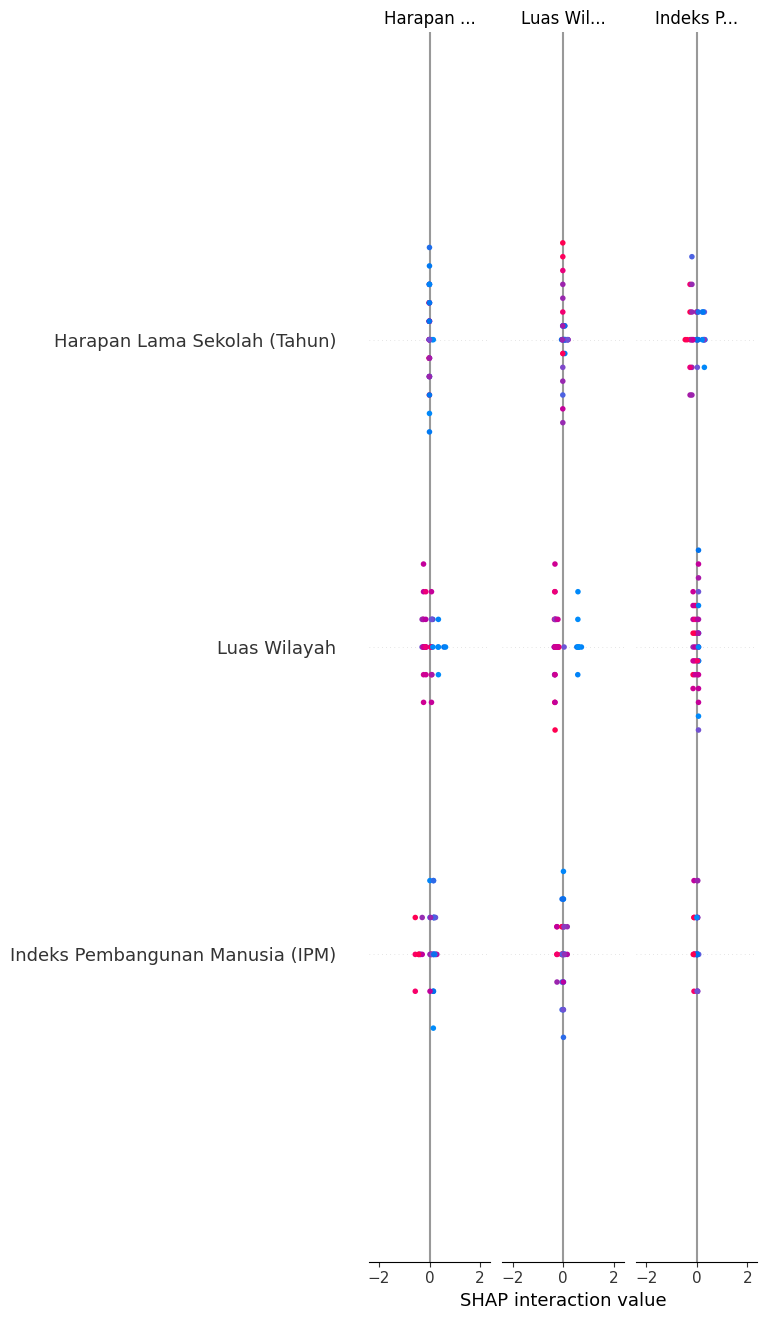

In [14]:
import shap
import matplotlib.pyplot as plt

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=15)
shap.summary_plot(shap_values, X_test, max_display=15)


/tmp/ipython-input-3920998581.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_test, palette="Set2", alpha=0.7, label="Aktual")
/tmp/ipython-input-3920998581.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_pred, palette="Set1", alpha=0.5, label="Prediksi")


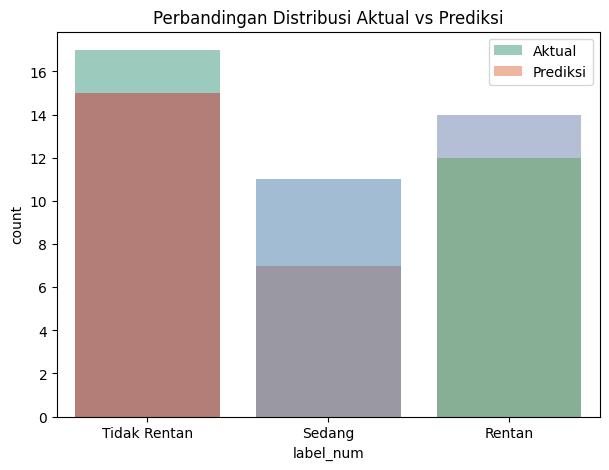

In [15]:
plt.figure(figsize=(7,5))
sns.countplot(x=y_test, palette="Set2", alpha=0.7, label="Aktual")
sns.countplot(x=y_pred, palette="Set1", alpha=0.5, label="Prediksi")
plt.xticks([0,1,2], ["Tidak Rentan","Sedang","Rentan"])
plt.title("Perbandingan Distribusi Aktual vs Prediksi")
plt.legend(["Aktual","Prediksi"])
plt.show()

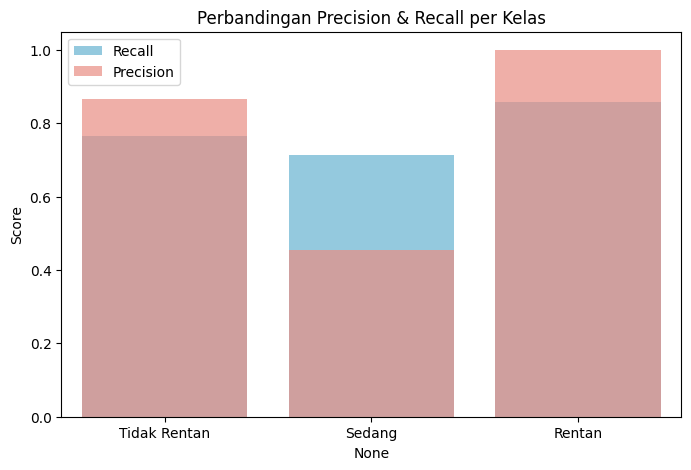

In [16]:
report = classification_report(y_test, y_pred, target_names=["Tidak Rentan","Sedang","Rentan"], output_dict=True)
df_report = pd.DataFrame(report).transpose()

plt.figure(figsize=(8,5))
sns.barplot(x=df_report.index[:-3], y=df_report["recall"][:-3], color="skyblue", label="Recall")
sns.barplot(x=df_report.index[:-3], y=df_report["precision"][:-3], color="salmon", alpha=0.7, label="Precision")
plt.title("Perbandingan Precision & Recall per Kelas")
plt.ylabel("Score")
plt.legend()
plt.show()

In [18]:
data = pd.read_csv("prediksi_kemiskinan_kesejahteraan_testset.csv")
data.head(3)

,Luas Wilayah,Indeks Pembangunan Manusia (IPM),Harapan Lama Sekolah (Tahun),Rata-rata Lama sekolah (Tahun),Angka Partisipasi Sekolah (APS) Usia 7-12 (Persen),Angka Partisipasi Sekolah (APS) Usia 13-15 (Persen),Angka Partisipasi Sekolah (APS) Usia 16-18 (Persen),Angka Partisipasi Sekolah (APS) Usia 19-23 (Persen),Rasio Guru per Siswa,Persentase Penduduk (Persen),...,STATUS BALITA GIZI KURANG BB,STATUS BALITA KURUS BB TB,STATUS BALITA PENDEK TB U,PRODUKSI PADI (TON),jmlh_industri_Q1,jmlh_industri_Q2,jmlh_industri_Q3,jmlh_industri_Q4,Prediksi_Label_Num,Prediksi_Label
0,1669.87,70.65,13.20,6.90,99.28,98.93,69.59,11.28,10.63,1.68,...,18223.00,15497.0,15497.0,162236.8,1.329,1.334,1.362,1.377,2,Rentan
1,1115.09,75.16,13.61,8.77,99.74,98.37,84.42,21.30,14.30,3.26,...,50647.00,37842.0,37842.0,342291.3,2.958,3.030,3.091,3.194,1,Sedang
2,1790.90,68.48,12.02,6.87,99.95,97.33,53.00,15.25,13.86,2.76,...,7.15,6.2,6.2,300829.0,1.183,1.183,1.183,1.183,1,Sedang
